# Generic Content Analysis


## ⚠️ PLEASE READ BEFORE DOING ANYTHING ⚠️

Welcome to this online coding environment ! 
You are currently running a *Jupyter notebook* that we hope to be usefull for content analysis of questionnaires. 

>Each cell can be ran individually (pressing the "Play" ▶ button or pressing CTRL+ENTER in the each cell). In order to make everything run smoothly, it is **strongly** recommended to run them in order. 

>***RECOMMANDED:*** You can also run all the cells at the same time : "Run" → "Run All Cells".<br>
> ⚠️ If you choose this option and want to analyse your own data, we suggest that you configure correctly the `experiment`, `import_file` and `references` variables before running all the cells once, then adjust the `max_radius` variable of Figure 4. 

At the end of the execution, you will have the opportunity to save all yours results in an HTML file, executing `"File" → "Save and Export Notebook as" → "HTML"` 

If you have chosen to run every cell individually, please begin by running the following cell that imports all the required package for our code to work correctly ↓

In [140]:
%%capture
######### IMPORTS #########
import pandas as pd
import numpy as np 
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import normalize
from scipy.stats import spearmanr

import plotly.express as px
import plotly.graph_objects as go

from ipywidgets import Layout, FileUpload, Button, Box, VBox, HBox, Dropdown, Output, interactive_output, Checkbox, GridBox

from IPython.display import display
import asyncio
import io
from threading import Thread
############################

############## GLOBALS ##############
TYPE_XSL = "application/vnd.ms-excel"
TYPE_XLSX = "application/vnd.openxmlformats-officedocument.spreadsheetml.sheet"

df = None
#####################################

#Required package to download the image
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

---
# Data import

By default, this repository is configured to make you compute your own results (`experiment = "Custom"`), but we also configured it to reproduce some previous analyses:

* option `experiment = "Gauld2023_OSAS_content_analysis"` : Gauld C, Baillieul S, Martin VP, Richaud A, Pelou M, Abi-Saab P,Coelho J, Philip P, Pépin JL, Micoulaud-Franchi JA. 
What evaluate obstructive sleep apnea patient-based screening questionnaires? A systematic and quantified item content analysis. *Under review* 

* option `experiment = "Gauld2023_sleep_content_analysis"`: 
 Gauld C, Martin VP, Richaud A, Bailleul S, Lucie V, Perromat JL, Zreik I, Taillard J, Geoffroy PA, Lopez R, Micoulaud-Franchi JA. Systematic Item Content and Overlap Analysis of Self-reported Multiple Sleep Disorders Screening Questionnaires in Adults. *Journal of Clinical Medicine*. [https://doi.org/10.3390/jcm12030852](https://doi.org/10.3390/jcm12030852) 

* option `experiment = "Fried2017"` : Fried EI. The 52 symptoms of major depression: Lack of content overlap among seven common depression scales. *Journal of Affective Disorders*. 2017 Jan;208:191–7. 


## Correct symptom file formatting

For this notebook to work correcly, your symptom file should be formatted the following way : 
* the four first columns must be the category (named "Category" in our example), subcategory (named "Subcategory" in our example), the abbreviation for the symptom (as shown in the Figure, named "Ab" in our example) and the name of the symptom ("Symptom" in our example);
* the other columns are the different questionnaires, while the line are the different symptoms.
* For each questionnaire, the symptoms are coded the following way: 
    * 0: The symptom is absent from this questionnaire
    * 1: The symptom is specific in this questionnaire (i.e. the symptom has bene identified in an item mentionning only one symptom)
    * 2: The symptom is componed in this questionnaire (i.e. the symptom has bene identified in an item mentionning at least two symptom)

⚠️ If you do not have categories or subcategories, just put empty columns as first or second columns ⚠️

## Importing data by uploading an excel file 

To import your own file in the `binder` online folder : 
>* Open the online folder pressing the "folder" icon on the left 📁 
>* Click on the "Upload a file" button ⭱

Now adapt the `experiment`, `import_file` and `correspondance_table` (if needed) to your experiment !

In [141]:
class FileSelectionForm(VBox):
    def __init__(self):     
        self.dropdown = Dropdown(
            options=["Fried2017", "GauldMartin2022", "Custom"],
            value="GauldMartin2022",
            description="Expérience",
            disabled=False
        )
        self.filepicker = FileUpload(
            accept=".xsl, .xlsx",
            multiple=False,
            tooltip="Upload your excel file",
            layout=Layout(display='none'),
            disabled=False
        )
        self.confirm = Button(
            description="Confirm",
            icon="check",
            tooltip="Click here to confirm your selection",
            disabled=False
        )
        self.output = Output(
            layout=Layout(
                width="fit-content"
            )
        )
        
        VBox.__init__(
            self,
            children=[
                HBox(
                    children=[self.dropdown, self.filepicker],
                    layout=Layout(justify_content="flex-start", grid_gap="5px", width="100%")
                ),
                HBox(
                    children=[self.confirm],
                    layout=Layout(justify_content="flex-start", width="100%")
                ),
                self.output
            ],
            layout= Layout(
                width="max-content",
                grid_gap="10px",
                align_items="flex-start",
                overflow="visible"
            )
        )
        
        self.dropdown.observe(self._onDropdownChange, names="value")
        self.filepicker.observe(self._onFileUpload, names="value")
        self.confirm.on_click(self.confirmForm)
        
    def _onDropdownChange(self, change):
        if change["new"] == "Custom":
            self.filepicker.layout.display = ""
            if len(self.filepicker.value) == 0:
                self.confirm.disabled = True
        else :
            self.filepicker.layout.display = "none"
            self.confirm.disabled = False
            
    def _onFileUpload(self, change):
        files = change["new"]
        if len(files) > 0 and (files[0].type == TYPE_XLSX or files[0].type == TYPE_XSL):
            print(files[0].type)
            self.confirm.disabled = False
    
    def getForm(self):
        return self._layout
    
    def confirmForm(self, _):
        global df, experiment 
        experiment = self.dropdown.value
        if experiment == "Fried2017" : 
            df = pd.read_excel("./data/fried2017_reformatted.xlsx") # reproduction of the seminal paper of Fried et al. https://doi.org/10.1016/j.jad.2016.10.019
        elif experiment=="GauldMartin2022" : 
            df = pd.read_excel("./data/gauld2023_sleep_content_analysis_processed.xlsx")
        else :
            file = self.filepicker.value[0].content
            df = pd.read_excel(io.BytesIO(file))

        df.rename(columns={df.columns[0]: "Category", df.columns[1]: "Ab", df.columns[2]: "Symptom"}, inplace=True) #replacing the name of the three first columns !
        df.sort_values(by="Ab",inplace = True) # sort the dataset by abbreviation
        with self.output:
            self.output.clear_output()
            display(df.head()) # print the 5 first rows

In [43]:
display(FileSelectionForm())

FileSelectionForm(children=(HBox(children=(Dropdown(description='Expérience', index=1, options=('Fried2017', '…

In [120]:
class referenceSelectionForm(VBox):
    def init(self):
        listRef = list(df.columns)
        numCols = 2
        numRows = (len(listRef) + numCols - 1) // numCols

        self.checkBoxes = []
        for i in range(numRows):
            rowCheckboxes = [self.createCheckbox(idx, listRef) for idx in range(i, len(listRef), numRows)]
            self.checkBoxes.append(HBox(rowCheckboxes))

        self.tab = VBox(self.checkBoxes)
        self.output = Output(
            layout=Layout(
                width="fit-content"
            )
        )

        self.buttonGenerate = Button(
            description="Generate",
            icon="fa-play-circle",
            tooltip="Generate with the above references",
            disabled=False
        )

        VBox.init(
            self,
            children=[
                self.tab,
                HBox(
                    children=[self.buttonGenerate],
                    layout=Layout(justify_content="flex-start", grid_gap="5px", width="100%")
                )
            ],
            layout= Layout(
                width="max-content",
                grid_gap="10px",
                align_items="flex-start",
                overflow="visible"
            )
        )

        with self.output:
            display(self.tab)

    def createCheckbox(self, idx, listRef):
        return Checkbox(
            value=False,
            description=listRef[idx],
            disabled=False
        )
    
display(referenceSelectionForm())

referenceSelectionForm()

In [191]:
if experiment == "Fried2017" or experiment == "Gauld2023_OSAS_content_analysis" :
    references = []
elif experiment == "Gauld2023_sleep_content_analysis": 
    references = ['ICSD', 'DSM']
else : 
    references = ['ref1', 'ref2', '...'] #change here if you want to compare symmptoms of questionnaire with reference classifications

header = ['Category','Subcategory', 'Ab', 'Symptom']+references

class referenceSelectionForm(VBox):
    global references
    def __init__(self):
        listRef = list(df.columns)
        idx = 0
        self.checkBoxes = []
        for i in listRef:
            if i in header:
                newCheckBox = self.createCheckbox(idx, listRef, True)
            else:
                newCheckBox = self.createCheckbox(idx, listRef, False)
            idx+=1
            self.checkBoxes.append(newCheckBox)
        self.output = Output(
            layout=Layout(
                width="fit-content"
            )
        )
        
        self.buttonGenerate = Button(
            description="Generate",
            icon="fa-play-circle",
            tooltip="Generate with the above references",
            disabled=False
        )
        
        self.buttonGenerate.on_click(self.generateFigures)
    
        VBox.__init__(
            self,
            children=[
                GridBox(
                    self.checkBoxes, layout= Layout(grid_template_columns="repeat(3, 33%)")
                ),
                HBox(
                    children=[self.buttonGenerate],
                    layout=Layout(justify_content="flex-start", grid_gap="5px", width="100%")

                )
            ],
            layout= Layout(
                width="max-content",
                grid_gap="10px",
                align_items="flex-start",
                overflow="visible"
            )
        )
        
        with self.output:
            display(self.tab)
    
    def createCheckbox(self, idx, listRef, _value):
        return Checkbox(
            value=_value,
            description=listRef[idx],
            disabled=False
        )
    
    def generateFigures(self, _):
        selected_options = []
        for i in self.checkBoxes:
            if(i.value == True):
                selected_options.append(i.description)
        header = selected_options
        print(header)
        
display(referenceSelectionForm())

referenceSelectionForm(children=(GridBox(children=(Checkbox(value=True, description='Category'), Checkbox(valu…

In [192]:
# uncomment the analysis you want to run
#experiment = "Fried2017"
#experiment = "Gauld2023_sleep_content_analysis"
experiment = "Gauld2023_OSAS_content_analysis"
#experiment = "Custom"

if experiment == "Fried2017" : 
    df = pd.read_excel("./data/fried2017_reformatted.xlsx") # reproduction of the seminal paper of Fried et al. https://doi.org/10.1016/j.jad.2016.10.019
elif experiment=="Gauld2023_sleep_content_analysis" : 
    df = pd.read_excel("./data/gauld2023_sleep_content_analysis_processed.xlsx")
elif experiment=="Gauld2023_OSAS_content_analysis" : 
    df = pd.read_excel("./data/gauld2023_OSAS_data_processed.xlsx")
else :
    import_file = "./your_excel_file.xlsx"
    df = pd.read_excel(import_file)
    
df.rename(columns={df.columns[0]: "Category",df.columns[1]: "Subcategory", df.columns[2]: "Ab", df.columns[3]: "Symptom"}, inplace=True) #replacing the name of the three first columns !
df.sort_values(by="Ab",inplace = True) # sort the dataset by abbreviation
df.head() # print the 5 first rows

Category                              Subcategory    Ab  \
0  OSA symptoms                                  Snoring  S001   
1  OSA symptoms                                  Snoring  S002   
2  OSA symptoms  Breath abnormalities-related complaints  S003   
3  OSA symptoms  Breath abnormalities-related complaints  S004   
4  OSA symptoms  Breath abnormalities-related complaints  S005   

                                             Symptom  GOAL  NoSAS  STOP  \
0                                            Snoring     0      1     0   
1                                       Loud Snoring     1      0     1   
2           Self-complaints of breath abnormalities      0      0     0   
3  Breath abnormalities complaints reported by other     0      0     0   
4                                           Sweating     0      0     0   

   STOP-Bang  Berlin  OSA 50  ASA  Wisconsin Q  SA-SDQ  Haraldsson  AS  
0          0       1       0    1            1       0           1   2  
1          1       1       0    1            1       1           0   2  
2          0       0       0    2            0       1           0   0  
3          0       1       1    0            0       0           0   0  
4          0       0       0    0            0       1           0   0

## Reference classifications
In the `Gauld2023_sleep_content_analysis` paper, we compare the symptoms of the questionnaires with two references classification (ICSD and DSM). If you have reference columns that you want to compare with but you do not want to compute metrics on, please put them in this table. Otherwise, just let this list empty [ ].

⚠️ the name of the references should match PERFECTLY the name of the columns they are in (including uppercases and lowercases, or spaces) ⚠️

In [128]:
if experiment == "Fried2017" or experiment == "Gauld2023_OSAS_content_analysis" :
    references = []
elif experiment == "Gauld2023_sleep_content_analysis": 
    references = ['ICSD', 'DSM']
else : 
    references = ['ref1', 'ref2', '...'] #change here if you want to compare symmptoms of questionnaire with reference classifications

header = ['Category','Subcategory', 'Ab', 'Symptom']+references

# Ordering questionnaires and symptoms

First, the questionnaires are classified from having the higher number of symptoms to the lowest.

In [193]:
sums = (df.drop(header,axis = 1)>=1).sum(axis = 0) # sum of the number of symptom by questionnaire
col = list(sums.sort_values(ascending=False).index.to_numpy()) #we create the list of columns
col = header + col
# we apply the order of columns to the dataset
df = df.loc[:, col]
df.head()

Category                              Subcategory    Ab  \
0  OSA symptoms                                  Snoring  S001   
1  OSA symptoms                                  Snoring  S002   
2  OSA symptoms  Breath abnormalities-related complaints  S003   
3  OSA symptoms  Breath abnormalities-related complaints  S004   
4  OSA symptoms  Breath abnormalities-related complaints  S005   

                                             Symptom  ASA  SA-SDQ  STOP-Bang  \
0                                            Snoring    1       0          0   
1                                       Loud Snoring    1       1          1   
2           Self-complaints of breath abnormalities     2       1          0   
3  Breath abnormalities complaints reported by other    0       0          0   
4                                           Sweating    0       1          0   

   Berlin  Haraldsson  NoSAS  STOP  GOAL  OSA 50  AS  Wisconsin Q  
0       1           1      1     0     0       0   2            1  
1       1           0      0     1     1       0   2            1  
2       0           0      0     0     0       0   0            0  
3       1           0      0     0     0       1   0            0  
4       0           0      0     0     0       0   0            0

In [194]:
#order of symptoms: most common first (independtly from 'specific' or 'compound').
df['sum_symptoms'] = (df.drop(header,axis = 1)>=1).sum(axis = 1)
df.sort_values(by=['sum_symptoms','Ab'], ascending = [False,True], inplace = True)
df.head()

Category                        Subcategory    Ab  \
5               OSA symptoms  Breath abnormalities observations  S006   
1               OSA symptoms                            Snoring  S002   
0               OSA symptoms                            Snoring  S001   
19  Clinical characteristics                     Anthropometric  S020   
9     Sleep-related symptoms                         Sleepiness  S010   

                        Symptom  ASA  SA-SDQ  STOP-Bang  Berlin  Haraldsson  \
5   Stop breathing observations    1       1          1       1           1   
1                  Loud Snoring    1       1          1       1           0   
0                       Snoring    1       0          0       1           1   
19                          BMI    1       1          1       1           0   
9                       Fatigue    2       0          2       1           2   

    NoSAS  STOP  GOAL  OSA 50  AS  Wisconsin Q  sum_symptoms  
5       0     1     0       1   1            1             9  
1       0     1     1       0   2            1             8  
0       1     0     0       0   2            1             6  
19      1     0     1       0   0            0             6  
9       0     2     0       0   0            0             5

---
# 1. Analysis of the number and frequency of symptoms

In a first step, we analyse the frequency of the symptoms.

## Histogram of number of symptoms

### Sorted by number of occurences

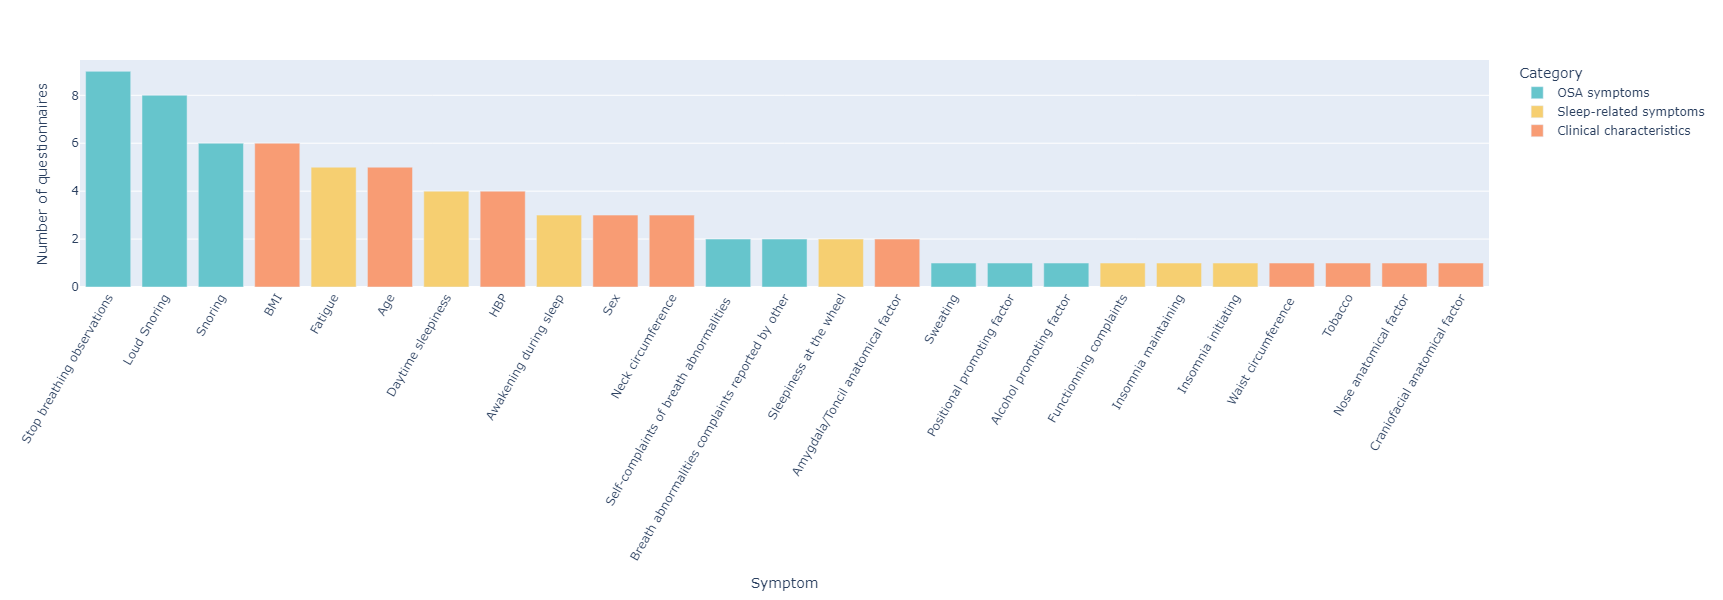

In [195]:
df_questionnaires = df.drop(references, axis = 1)
if df.shape[0] != df['Category'].isnull().sum() : 
    color = 'Category'
else : 
    color = "sum_symptoms"
fig = px.bar(df_questionnaires.sort_values(by=['sum_symptoms','Ab'],ascending = [False,True]),
             x='Symptom',
             y='sum_symptoms',
             color=color,
             labels={'sum_symptoms':'Number of questionnaires'},
             color_discrete_sequence =  px.colors.qualitative.Pastel, ## more color palettes available here : https://plotly.com/python/builtin-colors
             category_orders = {'Category':df_questionnaires.sort_values(by='Ab').Category.unique()}
             )
fig.update_layout(xaxis_tickangle=-60,autosize=False, width=1500, height=600, 
                  #xaxis={'categoryorder': 'total descending'}
                  xaxis={'categoryorder':'array', 'categoryarray':df_questionnaires.Symptom.unique()},
                  )
#fig.write_image("figure1_histogram_1.pdf")
fig.show()

The figure has been save in the online folder (📁 symbol on the left) under the name [figure1_histogram_1.pdf](figure1_histogram_1.pdf). <br>You can change the name and the format of the file changing the name in the `#fig.write_image()` function. 
<br>⚠️ If you need it, save the figure on your local computer : these online file will be deleted as soon as you quit this page!

### Sorted by category

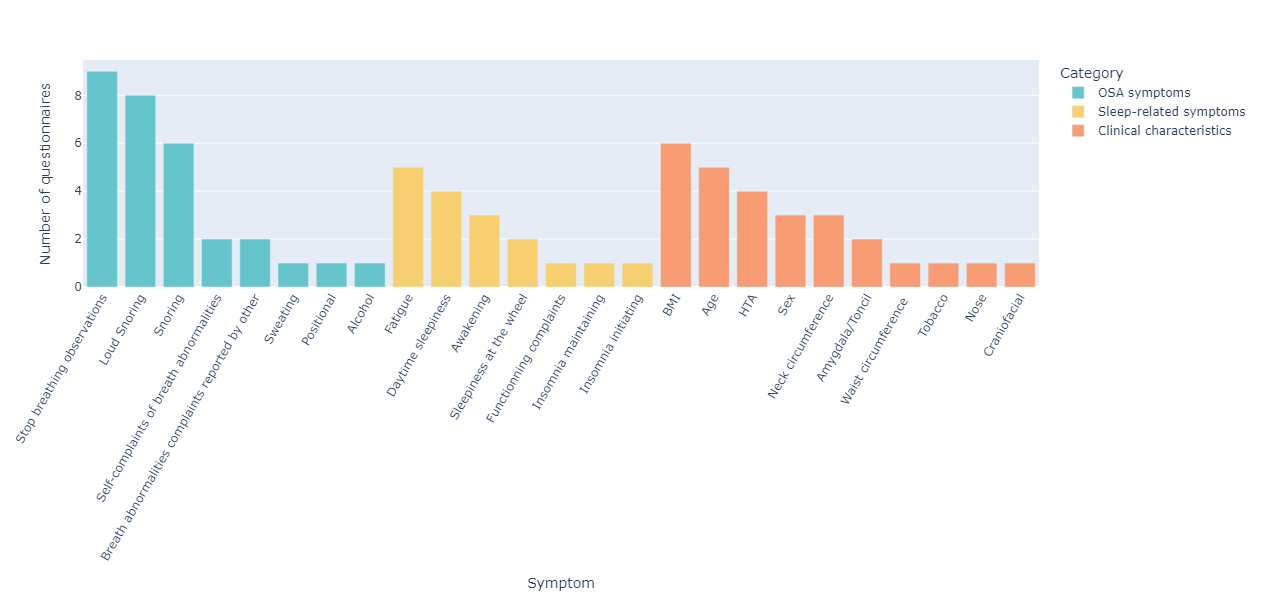

In [132]:
if df.shape[0] != df['Category'].isnull().sum() : 
    color = 'Category'
else : 
    color = "sum_symptoms"
fig = px.bar(df_questionnaires.sort_values(by=['sum_symptoms','Ab'],ascending = [False,True]),
             x='Symptom',
             y='sum_symptoms',
             color=color,
             labels={'sum_symptoms':'Number of questionnaires'},
             color_discrete_sequence =  px.colors.qualitative.Pastel, # more color palettes available here : https://plotly.com/python/builtin-colors
             category_orders = {'Category':df_questionnaires.sort_values(by='Ab').Category.unique()}
            )
fig.update_layout(xaxis_tickangle=-60,autosize=False, width=1500, height=600)
#fig.write_image("figure2_histogram_2.pdf")
fig.show()

The figure has been save in the online folder (📁 symbol on the left) under the name [figure2_histogram_2.pdf](figure2_histogram_2.pdf). <br>You can change the name and the format of the file changing the name in the `#fig.write_image()` function. 
<br>⚠️ If you need it, save the figure on your local computer : these online file will be deleted as soon as you quit this page!

## Number of symptoms by questionnaire

In [133]:
sympt_per_questionnaire = pd.DataFrame(np.zeros((df.shape[1]-5,3)), index = df.iloc[:,4:-1].columns, columns = ['Specific symptoms', 'Compound symptoms', 'Total'])
sympt_per_questionnaire['Specific symptoms'] = (df.iloc[:,4:-1]==1).sum(axis = 0)
sympt_per_questionnaire['Compound symptoms'] = (df.iloc[:,4:-1]==2).sum(axis = 0)
sympt_per_questionnaire['Total'] = (df.iloc[:,4:-1]>=1).sum(axis = 0)
sympt_per_questionnaire.to_excel("table1_symptomes_per_questionnaire.xlsx")

display(sympt_per_questionnaire)

Specific symptoms  Compound symptoms  Total
ASA                          9                  4     13
SA-SDQ                      10                  1     11
STOP-Bang                    7                  2      9
Berlin                       8                  1      9
Haraldsson                   3                  4      7
NoSAS                        5                  0      5
STOP                         3                  2      5
GOAL                         4                  0      4
OSA 50                       4                  0      4
AS                           2                  2      4
Wisconsin Q                  3                  0      3

The table has been save in the online folder (📁 symbol on the left) under the name [table1_symptoms_per_questionnaire.xlsx](./table1_symptoms_per_questionnaire.xlsx). <br>You can change the name and the format of the file changing the name in the `sympt_per_questionnaire.to_excel()` function. 
<br>⚠️ If you need it, save the excel file on your local computer : these online file will be deleted as soon as you quit this page!

## Symptoms that are in classifications but not in questionnaires

In [134]:
if len(references) > 0 :
  for ref in references: 
    print("---", ref, "---")
    for symptom in df.Symptom.unique() : 
      if (int(df.loc[df.Symptom == symptom,ref]) == 1 and int(df.loc[df.Symptom == symptom, 'sum_symptoms'])==0) : 
        print(symptom)
else : 
    print("References list is empty")

References list is empty


## Number of symptoms in each category for each questionnaire

In [135]:
# number of categories/questionnaire
if df.shape[0] != df['Category'].isnull().sum() : 
  cat_per_questionnaire = pd.DataFrame(np.zeros((df.shape[1]-5,len(df.Category.unique()))), index = df.iloc[:,4:-1].columns, columns = df.sort_values(by="Ab").Category.unique())
  for category in df.Category.unique():
    cat_per_questionnaire.loc[:,category] = (df[df.Category==category].iloc[:,4:-1]>=1).sum(axis = 0)
  display(cat_per_questionnaire.T)
  cat_per_questionnaire.T.to_excel("table2_categorie_per_questionnaire.xlsx")
else : 
  print('No category in this dataframe !')

ASA  SA-SDQ  STOP-Bang  Berlin  Haraldsson  NoSAS  \
OSA symptoms                4       6          2       4           2      1   
Sleep-related symptoms      4       1          2       3           5      0   
Clinical characteristics    5       4          5       2           0      4   

                          STOP  GOAL  OSA 50  AS  Wisconsin Q  
OSA symptoms                 2     1       2   3            3  
Sleep-related symptoms       2     0       0   0            0  
Clinical characteristics     1     3       2   1            0

The table has been save in the online folder (📁 symbol on the left) under the name [table2_categorie_per_questionnaire.xlsx](./table2_categorie_per_questionnaire.xlsx). <br>You can change the name and the format of the file changing the name in the `cat_per_questionnaire.T.to_excel()` function. 
<br>⚠️ If you need it, save the excel file on your local computer : these online file will be deleted as soon as you quit this page!

## Distribution across the categories of the symptoms measured by each questionnaire
(i.e. same thing as before, but normalized by questionnaire (sum across lines equals 1)).

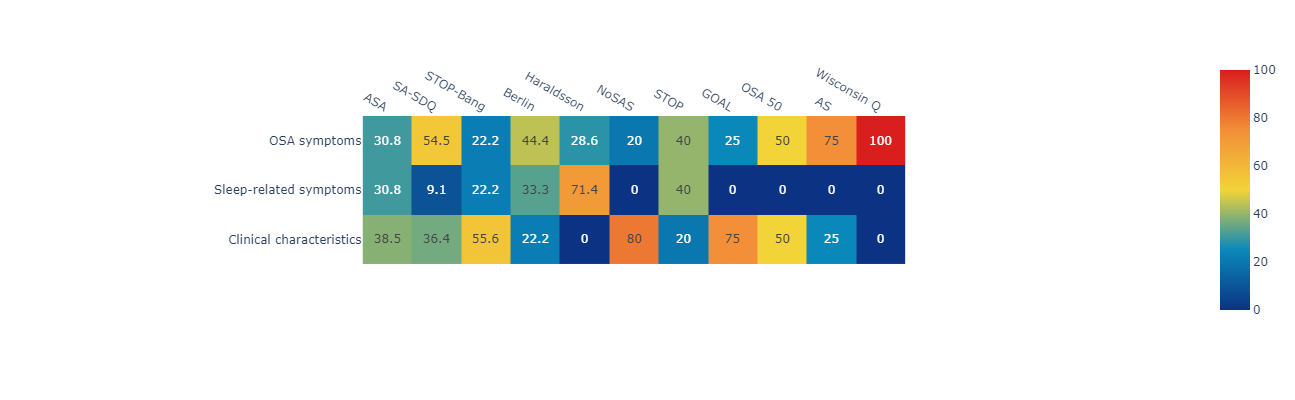

In [136]:
if df.shape[0] != df['Category'].isnull().sum() : 
  fig = px.imshow(pd.DataFrame(np.round(normalize(cat_per_questionnaire,norm='l1').T*100,1), # for printing text, we round the percentages to 1 decimal
                              columns = cat_per_questionnaire.index,
                              index= cat_per_questionnaire.columns),
                  text_auto=True, # add the text
                  color_continuous_scale= 'Portland'# more color palettes available here : https://plotly.com/python/builtin-colorscales/
  )
  fig.update_xaxes(side="top") # xaxis on top of the figure
  fig.update_layout(
    autosize=False,
    width=800,
    height=400
    )
  #fig.write_image("figure3_heatmap.pdf") # writing the figure in a file
  fig.show() # showing the figure
else : 
  print('No category in this dataframe !')

Figure 3 has been save in the online folder (📁 symbol on the left) under the name [figure3_heatmap.pdf](figure3_heatmap.pdf). You can change the name and the format of the file changing the name in the `#fig.write_image()` function. 
<br>⚠️ If you need it, save the figure on your local computer : these online file will be deleted as soon as you quit this page!

---
# 2. Analysis and data vizualisation of content analysis Figure

## Changing shape of data

In [137]:
# changing the shape of data
df_col = df.melt(id_vars=['Category','Subcategory','Ab', 'Symptom'], value_vars=col).copy()
df_col.head()

Category                        Subcategory    Ab  \
0              OSA symptoms  Breath abnormalities observations  S006   
1              OSA symptoms                            Snoring  S002   
2              OSA symptoms                            Snoring  S001   
3  Clinical characteristics                     Anthropometric  S020   
4    Sleep-related symptoms                         Sleepiness  S010   

                       Symptom variable  value  
0  Stop breathing observations      ASA      1  
1                 Loud Snoring      ASA      1  
2                      Snoring      ASA      1  
3                          BMI      ASA      1  
4                      Fatigue      ASA      2

## Content Analysis Figure

If you want to analyse custom data, you will have to set the variable `max_radius` so that the figure have the desired look !

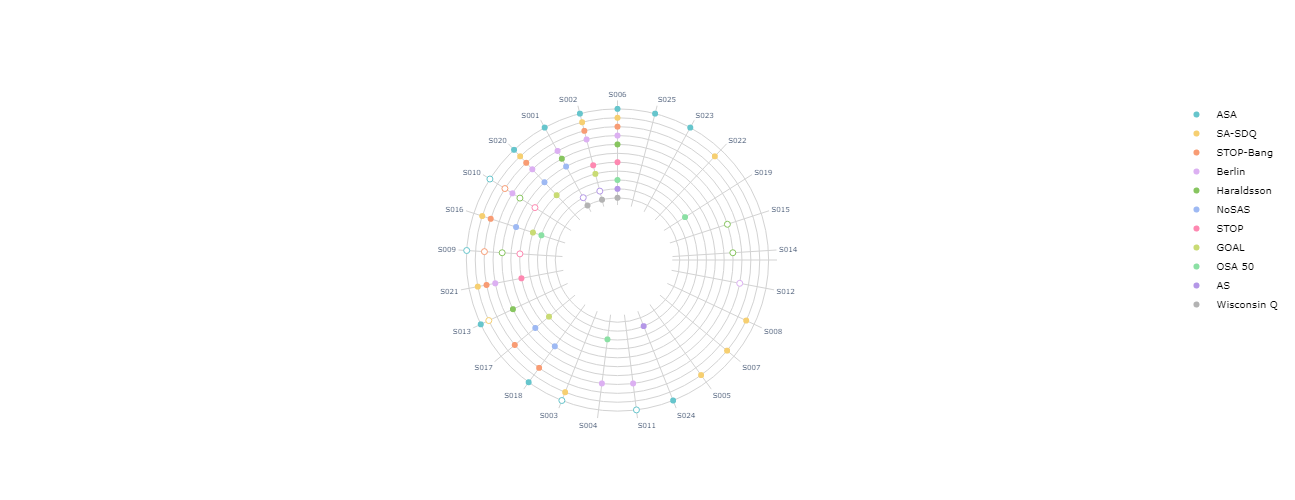

In [138]:
###
# PARAMETERS
###
if experiment == "Fried2017" :
    max_radius = 13
elif experiment == "Gauld2023_sleep_content_analysis" : 
    max_radius = 20 # maximum radius on the final figure
elif experiment == "Gauld2023_OSAS_content_analysis" : 
    max_radius = 17 # maximum radius on the final figure
else : 
    max_radius = 100 # <- /!\ value to set /!\ !!!
min_radius = 6.2 # minimum intern radius

# dictionnary questionnaire <->  radius of the circles
dic = {}
i = max_radius
for scale in df_col.variable.unique() : 
    dic[scale] = i
    i-=1

# dictionnary scale <-> color
palette = px.colors.qualitative.Pastel # choice of the palette. More choice in the following documentation : https://plotly.com/python/builtin-colorscales/
i = 0
dic_color = {}
# circular attribution of the colors (at the end of the palette, we go back to the beginning)
for scale in df_col['variable'].unique() : 
    if i>len(palette)-1 : 
        i = 0
    dic_color[scale] =palette[i]
    i+=1

###
# FIGURE
###
    
fig = go.Figure()
# transparency plot with all the symptoms to set their order in the plot
fig.add_trace(go.Scatterpolar(
            r = [0 for k in range(len(df.index))], # list of radiuses
            theta = df.Ab, # list of angles
            mode = 'markers',
            showlegend = False, # no legend thanks
        opacity = 0.0, # everything transparent !
    ))

if df.shape[0] == df['Category'].isnull().sum() : 
    df_col.loc[:,'Category'] = ""

### specific symptoms (value == 1)
df_spe = df_col[df_col.value == 1].copy() # we isolate only the specific symptoms
for scale in df_spe.variable.unique() : 
    temp = df_spe[df_spe.variable==scale] # dataframe with the data of each scale
    fig.add_trace(go.Scatterpolar(
            r = [dic[scale] for k in range(temp.shape[0])], # constant radius corresponding to the dictionnary value
            theta = temp.Ab, # angle = symptom 
            mode = 'markers',
        name = scale, # name in the legend
        hoverinfo="text", # type of hover. 'text' means that we design it by hand.
        hovertext= "Scale: "+scale+"<br>"+"Sympt.:"+temp.Symptom + "<br>Specific"+"<br>Category: "+temp.Category, # \n is <br> (html)
        # if category column in not empty
        
        opacity = 1.0,
        marker=dict( #property of the markers
            color = dic_color[scale], # color depending on the scale 
            symbol = "circle", # we want filled circles
            line=dict( # property of the line of the markers
                width=0 # we do not want line !
            ))
    ))

### component symptoms (=2)
df_comp = df_col[df_col.value == 2].copy()# we isolate only the compound symptoms
for scale in df_comp.variable.unique() : 
    temp = df_comp[df_comp.variable==scale] # dataframe with the data of each scale
    fig.add_trace(go.Scatterpolar(
            r = [dic[scale] for k in range(temp.shape[0])], # constant radius corresponding to the dictionnary value
            theta = temp.Ab,  # angle = symptom 
            mode = 'markers',
        hoverinfo="text",
        hovertext= "Scale: "+scale+"<br>"+"Sympt.:"+temp.Symptom + "<br>Compound"+"<br>Category: "+temp.Category, # \n is <br> (html)
        showlegend = False, # no legend
        marker=dict( # properties of the markers
            color = 'white', # white circle with color line
            symbol = "circle",
            line=dict(
                color=dic_color[scale], # color of the line
                width=1, # width of the line
         ))
    ))
    i+=1
    
### white circle in the center
fig.add_trace(go.Scatterpolar(
    r=[min_radius for k in range (len(df.Ab))], # radius of the circle = min_radius (set before)
    theta=df.Ab, # all angles
    fill='toself',
    fillcolor = "white", # color of the circle
    showlegend = False, # no legend
    line=dict(
    color="white",
    width=0, # no line
        ))
)


### Set options common to all traces with fig.update_traces

fig.update_polars(bgcolor='white')
fig.update_layout(
    autosize=True, # to allow or not autosize
    width=600, # width of the figure
    height=500, # height of the figure
    paper_bgcolor = 'rgba(0,0,0,0)', plot_bgcolor= 'rgba(0,0,0,0)',# background color
    polar = dict( #options for the polar plot
          radialaxis = dict(visible = True, # allowing radius lines  
                            color="lightgrey", # color of the lines
                            gridcolor = "lightgrey", # color of the grid
                            linecolor="lightgrey", #color of the lines
                            gridwidth = 1, # step in the grid
                            range=[0, max_radius+1], # range of the grid
                            dtick=1, # step in the grid
                            showgrid =True, # showing the grid
                            layer="below traces", # put the grid below traces
                            tickfont_color ='rgba(0,0,0,0)'),# putting tickfont into white to make them disappear
          angularaxis = dict(
        gridcolor = "lightgrey", # color of the angular grid
        tickfont_size=7, # font size of labels (ex. "S01")
        rotation=90, # start position of angular axis 
        direction="counterclockwise" # changin direction to align with Fried et al. 
        )),
        legend = dict(font = dict(size = 10, color = "black")) # size and color of the legend
)


#fig.write_image("figure4_radial.pdf") #saving figure into a file
fig.show() # showing figure

The figure has been save in the online folder (📁 symbol on the left) under the name [figure4_radial.pdf](figure4_radial.pdf). You can change the name and the format of the file changing the name in the `#fig.write_image()` function. 
<br>⚠️ If you need it, save the figure on your local computer : these online file will be deleted as soon as you quit this page!

## Overlap between questionnaires - Jaccard Index

In order to estimate the overlap between the symptoms measured by the questionnes, calculate the Jaccard index, which is defined as the number of symmtoms that are measured by both questionnaires, divided by the number of unique symptoms measured both questionnaires.

### Jaccard index of symptom for each pair of questionnaire
First, we compute the Jaccard index for each pair of questionnaires and plot it using a heatmap.

In [197]:
###
# Computing the table
###
jaccard_table = pd.DataFrame(np.zeros((df.shape[1]-5,df.shape[1]-5)), index = df.columns[4:-1], columns = df.columns[4:-1]) # df.columns[3:-1] : questionnaires without header
for questionnaire1 in df.columns[4:-1] : 
  for questionnaire2 in df.columns[4:-1] : 
    jaccard_table.loc[questionnaire1, questionnaire2] = jaccard_score(df[questionnaire1]>=1, df[questionnaire2]>=1)
    
display(jaccard_table)
jaccard_table.to_excel("table3_jaccard_pairs.xlsx")

ASA    SA-SDQ  STOP-Bang    Berlin  Haraldsson     NoSAS  \
ASA          1.000000  0.263158   0.375000  0.375000    0.333333  0.200000   
SA-SDQ       0.263158  1.000000   0.333333  0.250000    0.125000  0.142857   
STOP-Bang    0.375000  0.333333   1.000000  0.384615    0.230769  0.400000   
Berlin       0.375000  0.250000   0.384615  1.000000    0.230769  0.166667   
Haraldsson   0.333333  0.125000   0.230769  0.230769    1.000000  0.090909   
NoSAS        0.200000  0.142857   0.400000  0.166667    0.090909  1.000000   
STOP         0.285714  0.230769   0.555556  0.400000    0.333333  0.000000   
GOAL         0.133333  0.250000   0.444444  0.181818    0.000000  0.500000   
OSA 50       0.062500  0.153846   0.181818  0.181818    0.100000  0.125000   
AS           0.307692  0.153846   0.181818  0.300000    0.222222  0.125000   
Wisconsin Q  0.230769  0.166667   0.200000  0.333333    0.250000  0.142857   

                 STOP      GOAL    OSA 50        AS  Wisconsin Q  
ASA          0.285714  0.133333  0.062500  0.307692     0.230769  
SA-SDQ       0.230769  0.250000  0.153846  0.153846     0.166667  
STOP-Bang    0.555556  0.444444  0.181818  0.181818     0.200000  
Berlin       0.400000  0.181818  0.181818  0.300000     0.333333  
Haraldsson   0.333333  0.000000  0.100000  0.222222     0.250000  
NoSAS        0.000000  0.500000  0.125000  0.125000     0.142857  
STOP         1.000000  0.125000  0.125000  0.285714     0.333333  
GOAL         0.125000  1.000000  0.142857  0.142857     0.166667  
OSA 50       0.125000  0.142857  1.000000  0.142857     0.166667  
AS           0.285714  0.142857  0.142857  1.000000     0.750000  
Wisconsin Q  0.333333  0.166667  0.166667  0.750000     1.000000

Table 3 has been save in the online folder (📁 symbol on the left) under the name [table3_jaccard_pairs.xlsx](./table3_jaccard_pairs.xlsx). <br>You can change the name and the format of the file changing the name in the `jaccard_table.to_excel()` function. 
<br>⚠️ If you need it, save the excel file on your local computer : these online file will be deleted as soon as you quit this page!

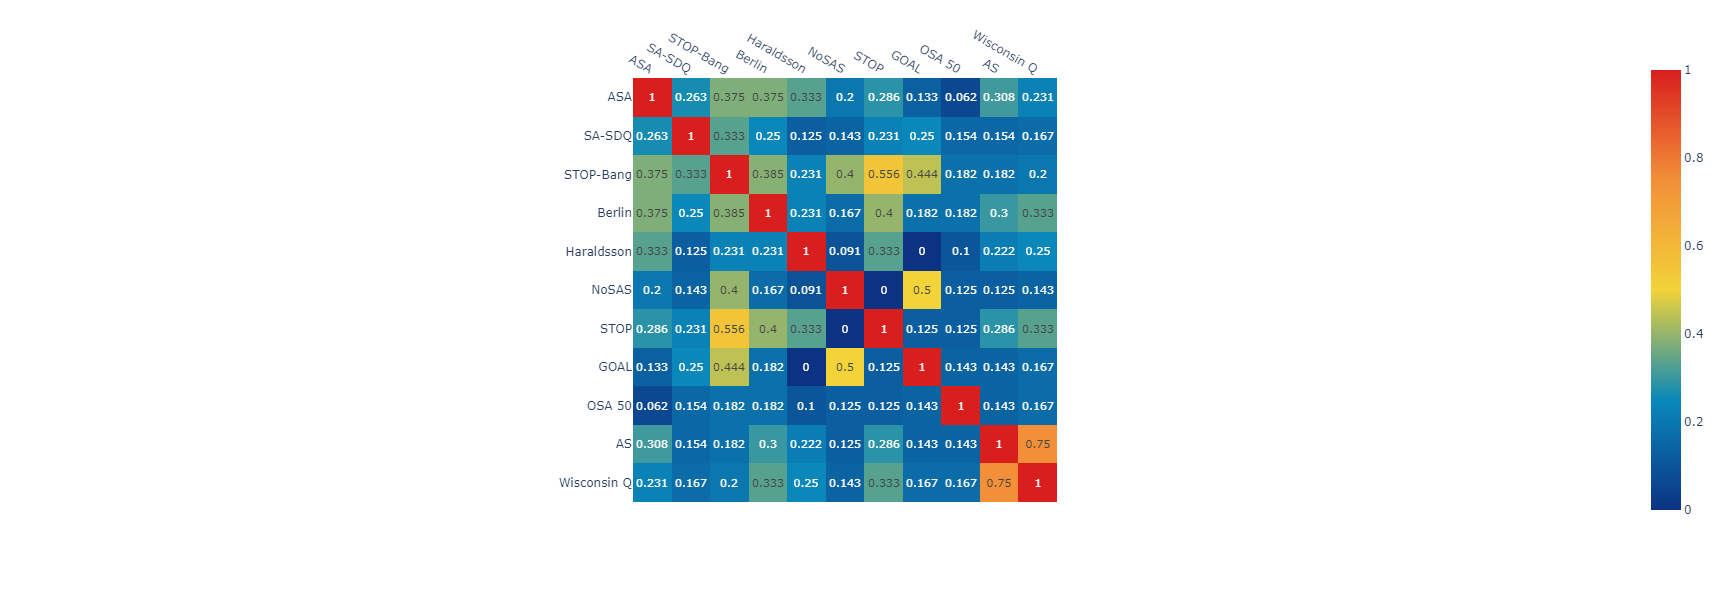

In [198]:
###
# Plotting it as a heatmap
###
fig = px.imshow(pd.DataFrame(np.round(jaccard_table,3), # rounding values for the plot
                             index = jaccard_table.index,
                             columns= jaccard_table.columns),
                text_auto=True, # annotating values in the plot
                color_continuous_scale= 'Portland'# more color palettes available here : https://plotly.com/python/builtin-colorscales/
)
fig.update_xaxes(side="top")
fig.update_layout(
    autosize=False,
    width=600,
    height=600
    )
#fig.write_image("figure5_heatmap_jaccard.pdf") # writting the figure into a file
fig.show() # showing figure

The figure has been save in the online folder (📁 symbol on the left) under the name [figure5_heatmap_jaccard.pdf](figure5_heatmap_jaccard.pdf). <br>You can change the name and the format of the file changing the name in the `#fig.write_image()` function. 
<br>⚠️ If you want it, save the figure on your local computer : these online file will be deleted as soon as you quit this page!

### Avg. Jaccard index
Then, we compute the average of Jaccard index for each questionnaire with other questionnaires (excluding the references). 

In [199]:
jaccard = pd.DataFrame(np.zeros((len(df.drop(header+['sum_symptoms'],axis = 1).columns),1)), index = df.drop(header+['sum_symptoms'],axis = 1).columns, columns=['Avg. Jaccard Index'])
for questionnaire in df.drop(header+['sum_symptoms'], axis=1).columns : 
  jaccard.loc[questionnaire, 'Avg. Jaccard Index'] = jaccard_table.drop(references+[questionnaire], axis = 1).loc[questionnaire, :].mean()
display(jaccard)
jaccard.to_excel("table4_jaccard_average_questionnaires.xlsx")
print("Average Jaccard index (wo references): "+str(np.round(float(jaccard.mean()),5)) +" (sd: "+str(np.round(float(jaccard.std()),4))+ ")" )


Avg. Jaccard Index
ASA                    0.256650
SA-SDQ                 0.206948
STOP-Bang              0.328735
Berlin                 0.280402
Haraldsson             0.191634
NoSAS                  0.189329
STOP                   0.267442
GOAL                   0.208698
OSA 50                 0.138236
AS                     0.261201
Wisconsin Q            0.274029

Average Jaccard index (wo references): 0.23666 (sd: 0.0542)


Table 4 has been save in the online folder (📁 symbol on the left) under the name [table4_jaccard_average_questionnaires.xlsx](./table4_jaccard_average_questionnaires.xlsx). <br>You can change the name and the format of the file changing the name in the `jaccard.to_excel()` function. 
<br>⚠️ If you need it, save the excel file on your local computer : these online file will be deleted as soon as you quit this page!

### Correlation between the number of symptoms and the average Jacquart index for each questionnaire 

In [142]:
correlations = jaccard.join(sympt_per_questionnaire)
display(correlations)
print("Correlation between Jaccard Index and number of specific symptoms: ",spearmanr(correlations['Avg. Jaccard Index'], correlations['Specific symptoms']))
print("Correlation between Jaccard Index and number of compound symptoms: ",spearmanr(correlations['Avg. Jaccard Index'], correlations['Compound symptoms']))
print("Correlation between Jaccard Index and total number of symptoms: ",spearmanr(correlations['Avg. Jaccard Index'], correlations['Total']))

Avg. Jaccard Index  Specific symptoms  Compound symptoms  Total
ASA                    0.256650                  9                  4     13
SA-SDQ                 0.206948                 10                  1     11
STOP-Bang              0.328735                  7                  2      9
Berlin                 0.280402                  8                  1      9
Haraldsson             0.191634                  3                  4      7
NoSAS                  0.189329                  5                  0      5
STOP                   0.267442                  3                  2      5
GOAL                   0.208698                  4                  0      4
OSA 50                 0.138236                  4                  0      4
AS                     0.261201                  2                  2      4
Wisconsin Q            0.274029                  3                  0      3

Correlation between Jaccard Index and number of specific symptoms:  SpearmanrResult(correlation=0.0, pvalue=1.0)
Correlation between Jaccard Index and number of compound symptoms:  SpearmanrResult(correlation=0.24545784641604232, pvalue=0.46691618386154077)
Correlation between Jaccard Index and total number of symptoms:  SpearmanrResult(correlation=0.11521838449545894, pvalue=0.7358609458354772)


### Jaccard index of symptoms for each pair of questionnaire for each category

Computing the same metric (average of average) for each category of questionnaires.

In [143]:
if df.shape[0] != df['Category'].isnull().sum() : 
  res = pd.DataFrame(np.zeros((len(df.Category.unique()),1)), index = df.sort_values(by="Ab").Category.unique(), columns=['Avg. Jaccard Index'])
  for category in df.Category.unique() : 
      df_category = df.drop(header+['sum_symptoms'],axis = 1)[df.Category==category]
      df_category = df_category.iloc[:,(df_category.sum(axis = 0)!=0.0).to_numpy()] # we keep only the questionnaire with at least 1 symptom
      liste_avg = []
      for questionnaire1 in df_category.columns : 
        liste = []
        for questionnaire2 in df_category.columns : 
          if questionnaire1!= questionnaire2 :
            liste.append(jaccard_score(df_category[questionnaire1]>=1, df_category[questionnaire2]>=1))
        liste_avg.append(np.mean(liste))
      res.loc[category, 'Avg. Jaccard Index'] = np.mean(liste_avg)
  display(res)
  res.to_excel("table5_jaccard_categories.xlsx")

else : 
  print("Category is empty")

Avg. Jaccard Index
OSA symptoms                        0.393983
Sleep-related symptoms              0.319524
Clinical characteristics            0.213062

Table 5 has been save in the online folder (📁 symbol on the left) under the name [table5_jaccard_categories.xlsx](./table5_jaccard_categories.xlsx). <br>You can change the name and the format of the file changing the name in the `res.to_excel()` function. 
<br>⚠️ If you need it, save the excel file on your local computer : these online file will be deleted as soon as you quit this page!

Computing the same metric (average of average) for each subcategory.

In [144]:
if df.shape[0] != df['Subcategory'].isnull().sum() : 
  res = pd.DataFrame(np.zeros((len(df.Subcategory.unique()),1)), index = df.sort_values(by="Ab").Subcategory.unique(), columns=['Avg. Jaccard Index'])
  for subcategory in df.Subcategory.unique() : 
      df_subcategory = df.drop(header+['sum_symptoms'],axis = 1)[df.Subcategory==subcategory]
      df_subcategory = df_subcategory.iloc[:,(df_subcategory.sum(axis = 0)!=0.0).to_numpy()] # we keep only the questionnaire with at least 1 symptom
      liste_avg = []
      for questionnaire1 in df_subcategory.columns : 
        liste = []
        for questionnaire2 in df_subcategory.columns : 
          if questionnaire1!= questionnaire2 :
            liste.append(jaccard_score(df_subcategory[questionnaire1]>=1, df_subcategory[questionnaire2]>=1))
        liste_avg.append(np.mean(liste))
      res.loc[subcategory, 'Avg. Jaccard Index'] = np.mean(liste_avg)
  display(res)
  res.to_excel("table5b_jaccard_subcategories.xlsx")

else : 
  print("Subcategory is empty")

c:\Users\Vincent\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning:

Mean of empty slice.

c:\Users\Vincent\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\Vincent\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning:

Mean of empty slice.

c:\Users\Vincent\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



Avg. Jaccard Index
Snoring                                            0.555556
Breath abnormalities-related complaints            0.250000
Breath abnormalities observations                  1.000000
Context                                                 NaN
Sleepiness                                         0.625000
Awakening                                          1.000000
Insomnia                                                NaN
Sociodemographic                                   0.700000
Anthropometric                                     0.500000
Comorbidity                                        0.750000
Anatomical airway                                  0.333333

# Sunburst Plot

In [146]:
#replacing some wordings
if experiment == "Gauld2023_OSAS_content_analysis" : 
    df.replace("Stop breathing observations","Stop breathing <br> observations", inplace = True)
    df.replace("Self-complaints of breath abnormalities","Self-complaints of <br> breath abnormalities", inplace = True)
    df.replace("Breath abnormalities complaints reported by other","Breath abnormalities <br> complaints reported <br> by other", inplace = True)
    df.replace("Sociodemographic","Sociodem.", inplace = True)
    df.replace("Anthropometry","Antropo.", inplace = True)
    df.replace("Sleep-related symptoms","Sleep-related <br> symptoms", inplace = True)
    df.replace("Breath abnormalities complaints","Breath abn. compl.", inplace = True)
    df.replace("OSA symptoms","OSA <br> symptoms", inplace = True)
    df.replace("Clinical characteristics","Clinical <br> characteristics", inplace = True)
    df.replace("Breath abnormalities observations","Breath <br> abnormalities <br> observations", inplace = True)
    df.replace("Breath abnormalities-related complaints","Breath <br> abnormalities-related <br> complaints", inplace = True)

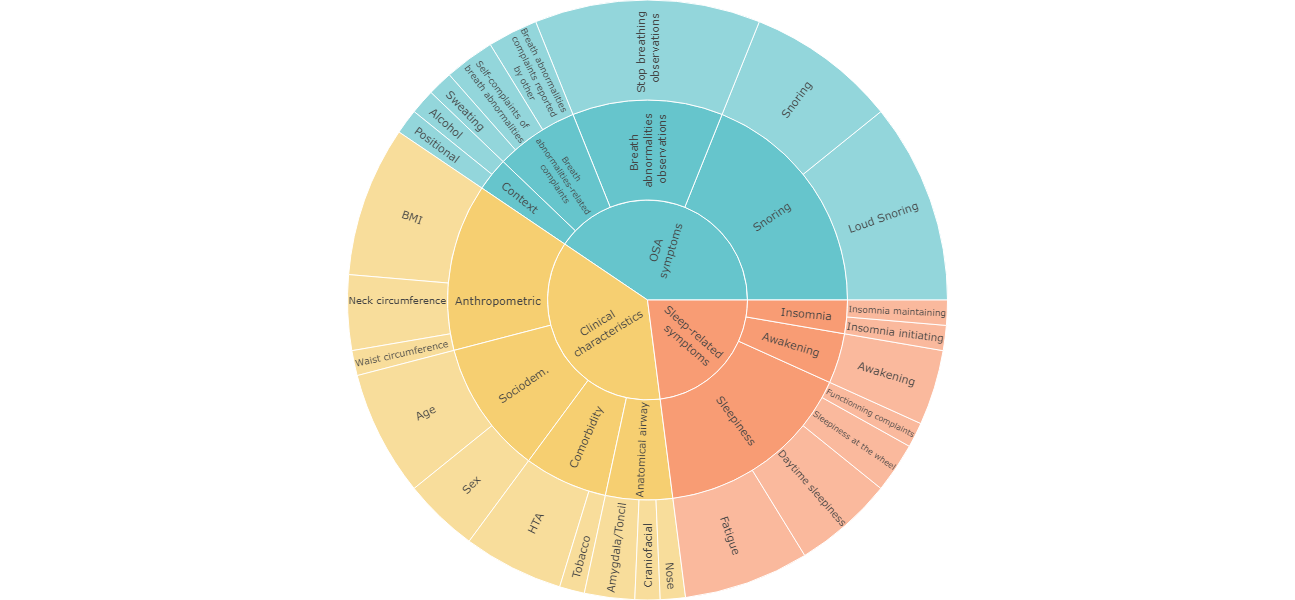

In [147]:
if np.sum(df.Subcategory.isna()) != df.shape[0] : # with category and subcategory
    fig = px.sunburst(df, path=['Category', 'Subcategory', 'Symptom'], values='sum_symptoms',color_discrete_sequence = px.colors.qualitative.Pastel)
    fig.update_layout(margin = dict(t=0, l=0, r=0, b=0), font_size=11, width =600, height = 600)
    fig.update_traces(insidetextorientation='radial')
    fig.update_traces(hovertemplate='sum_symptom: %{value}')
    #fig.write_image("figure6_sunburst_plot.pdf") # writting the figure into a file
    fig.show()
elif np.sum(df.Category.isna()) != df.shape[0] : # with category only
    fig = px.sunburst(df, path=['Category', 'Symptom'], values='sum_symptoms',color_discrete_sequence = px.colors.qualitative.Pastel)
    fig.update_layout(margin = dict(t=0, l=0, r=0, b=0), font_size=11, width =600, height = 600)
    fig.update_traces(insidetextorientation='radial')
    fig.update_traces(hovertemplate='sum_symptom: %{value}')
    #fig.write_image("figure6_sunburst_plot.pdf") # writting the figure into a file
    fig.show()
else : 
    print("No category -> no sunburst plot")


The figure has been save in the online folder (📁 symbol on the left) under the name [figure6_sunburst_plot.pdf](figure6_sunburst_plot.pdf). <br>You can change the name and the format of the file changing the name in the `#fig.write_image()` function. 
<br>⚠️ If you want it, save the figure on your local computer : these online file will be deleted as soon as you quit this page!

---
# Export to html
You have reached the end of this notebook. 
If you want to save the whole page, you can download it to html with dynamic figures:
>* "File" → "Save and Export Notebook as" → "HTML" 